In [1]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pysph.solver.utils import load, iter_output, get_files
import pandas as pd
sns.set_style("ticks", {'axes.facecolor': '#EAEAF2', 'axes.grid': True})
file_base = '/home/prajwal/Desktop/Winter_Project/SLP-Smoothed-Particle-Hydrodynamics/SLP/Elliptical-Drop/PySPH-Testing'


global savefig_additional 
global figTitle1
global figTitle2
global figTitle3

In [251]:
def _derivative(x, t):
    A, a = x
    Anew = A*A*(a**4 - 1)/(a**4 + 1)
    anew = -a*A
    return np.array((Anew, anew))


def _scipy_integrate(y0, tf, dt):
    from scipy.integrate import odeint
    result = odeint(_derivative, y0, [0.0, tf])
    return result[-1]


def _numpy_integrate(y0, tf, dt):
    t = 0.0
    y = y0
    while t <= tf:
        t += dt
        y += dt*_derivative(y, t)
    return y


def exact_solution(tf=0.0075, dt=1e-6, n=101):
    """Exact solution for the locus of the circular patch.

    n is the number of points to find the result at.

    Returns the semi-minor axis, A, pressure, x, y.

    Where x, y are the points corresponding to the ellipse.
    """
    import numpy

    y0 = np.array([100.0, 1.0])

    try:
        from scipy.integrate import odeint
    except ImportError:
        Anew, anew = _numpy_integrate(y0, tf, dt)
    else:
        Anew, anew = _scipy_integrate(y0, tf, dt)

    dadt = _derivative([Anew, anew], tf)[0]
    po = 0.5*-anew**2 * (dadt - Anew**2)

    theta = numpy.linspace(0, 2*numpy.pi, n)

    return anew, Anew, po, anew*numpy.cos(theta), 1/anew*numpy.sin(theta)

def extract_RT(file_loc):

    from os import walk
    files = []
    for (dirpath, dirnames, filenames) in walk(file_loc):
        files.extend(filenames)
        break

    fname = ''
    for i in files:
        if i.endswith('.log'):
            fname = i

    file_loc += '/' + fname
    data = open(file_loc, 'r')
    lines = data.read()
    rt = float(lines[lines.find('Run took: ')+10:].split(' secs')[0])
    data.close()

    return rt

def custom_plot1(sph_schm, sph_schm_legend, sz=(19.2,14.4), save=False):
    n = len(sph_schm)
    fig, axs = plt.subplots(2, 2, figsize=sz)

    cnt, RT = 0, []
    for schm in sph_schm:        
        file_loc = file_base + '/Outputs/' + schm + '/results.npz'
        data = np.load(file_loc) # Read data
        leg = sph_schm_legend[schm]
        

        t, ke = data['t'], data['ke']
        
        axs[0,0].plot(t, ke, linewidth=2, label=leg)

        mom = data['mom']
        axs[0,1].plot(t, mom, linewidth=2, label=leg)

        ymax = data['ymax']
        axs[1,0].plot(t, ymax, linewidth=2, label=leg)

        ymax_err = []
        for i in range(len(t)):
            a, A, po, xe, ye = exact_solution(t[i])
            ymax_err.append(np.abs(1 - ymax[i]*a)*100.0)

        axs[1,1].plot(t, ymax_err, linewidth=2, label=leg)

        cnt += 1
        if cnt == n:
            aa = []
            for tf in t:
                a, A, po, xe, ye = exact_solution(tf)
                aa.append(1.0/a)
            axs[1,0].plot(t, aa, 'k--', label='exact')

        file_loc = file_base + '/Outputs/' + schm 
        RT.append(extract_RT(file_loc))

    # Labels
    axs[1,0].set_xlabel(r't $\rightarrow$')
    axs[1,1].set_xlabel(r't $\rightarrow$')

    # Titles
    fig.suptitle(figTitle1, fontsize=24)
    axs[0,0].set_title('Kinetic Energy  vs Time', fontsize='large')
    axs[0,1].set_title(r'Linear Momentum History vs Time', fontsize='large')
    axs[1,0].set_title(r'Semi-Major Axis History vs Time', fontsize='large')
    axs[1,1].set_title(r'Semi-Major Axis History Error (%) vs Time', fontsize='large')

    fig.tight_layout()
    fig.subplots_adjust(top=0.9, bottom=0.1)
    lines = []
    labels = []
    for ax in fig.axes:
        axLine, axLabel = ax.get_legend_handles_labels()
        lines.extend(axLine)
        labels.extend(axLabel)
    
    n += 1
    lines, labels = lines[-n:][::-1], labels[-n:][::-1]

    p = n-1
    lines[:p], labels[:p] =  lines[:p][::-1], labels[:p][::-1]

    # Add Runtime scale
    RT = np.array(RT)
    RT_new = 100 * (RT - np.ones_like(RT)*np.min(RT)) / (np.ones_like(RT)*np.min(RT))

    for i in range(n-1):
        temp = RT_new[i]
        if temp == 0.0:
            rt = ' {' + str(round(RT[i], 1)) + 's}'
        else:
            rt = r' {' + str(round(temp, 2)) + r'$\% \uparrow$}'
        labels[i] = labels[i] + rt

    fig.legend(lines, labels, loc = 'lower center', ncol=n, prop={'size': 'medium'}, title=r'Legend {$\Delta \%$ Runtime}')

    if save == True:
        tle = file_base + '/ED_error_plot' + savefig_additional + '.png' 
        fig.savefig(tle, dpi=400)

def plot_loghist(x, bins = 20, ax = None, **plot_kwargs):
    if ax == None:
        ax = plt.gca()
    temp = min(x)
    if temp == 0:
        a = np.sort(x) == 0
        idx = np.where(a == False)[0][0]
        temp = np.sort(x)[idx]
        
    ax.hist(x, bins = 10 ** np.linspace(np.log10(temp), np.log10(max(x)), bins), **plot_kwargs)
    ax.set_xscale("log")
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    return(ax)

def combined_loghist(file_loc, ax = None, cond = 0.0, Bins=20, **plot_kwargs):
    if ax == None:
        ax = plt.gca()

    files = get_files(file_loc)
    df = np.array([])
    cnt = 0
    for solver_data, fluid in iter_output(files, 'fluid'):
        if cnt == 0:
            cnt = 1
        else:
            df = np.concatenate([df, fluid.DRh])
            cnt += 1

    cnt -= 1
    hist, bins = np.histogram(df, bins=Bins)
    hist_norm = hist / cnt

    width = 0.9 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    #ax.bar(center, hist_norm, align='center', width=width, log=True)
    plot_loghist(df, bins=Bins, ax=ax, log=True)

    temp = (df <= cond).sum()
    res = round(temp * 100/len(df), 3)
    return res

def custom_plot4(sph_schm, sph_schm_legend, bins = 20, sz=(19.2,14.4), save=False, vlines=None):
    from pysph.solver.utils import load, iter_output, get_files

    fig, axs = plt.subplots(2, 2, figsize=sz)
    i = 0
    for schm in sph_schm:       
        file_loc = file_base + '/Outputs/' + schm
        leg = sph_schm_legend[schm]

        if i <= 1:
            r = combined_loghist(file_loc, ax=axs[0,i%2], cond=vlines[i], bins=bins)
            leg += ' {' + str(r) + '%}'
            axs[0,i%2].set_title(leg, fontsize=20)
        else:
            r = combined_loghist(file_loc, ax=axs[1,i%2], cond=vlines[i], bins=bins)
            leg += ' {' + str(r) + '%}'
            axs[1,i%2].set_title(leg, fontsize=20)
        i += 1
    fig.suptitle(figTitle3, fontsize=24)

    fig.tight_layout()
    fig.subplots_adjust(top=0.85)

    if vlines != None:
        axs[0,0].axvline(x=vlines[0],c='k', linestyle='--')
        axs[0,1].axvline(x=vlines[1],c='k', linestyle='--')
        axs[1,0].axvline(x=vlines[2],c='k', linestyle='--')
        axs[1,1].axvline(x=vlines[3],c='k', linestyle='--')

    if save == True:
        tle = file_base + '/ED_DRH_plot' + savefig_additional + '.png' 
        fig.savefig(tle, dpi=400)


In [252]:
df = pd.read_csv(file_base + '/SPH Scheme - Test - ED.csv')
df

,Simulation Number,Scheme,PST,Kernel,nx,perturb,hdx,PST_Rh,PST_R_coeff,PST_n_exp
0,0,𝛿+ SPH,True,WendlandQuintic,40,0.2,1.5,0.05,0.0001,4
1,1,𝛿+ SPH,True,CubicSpline,40,0.2,2.0,0.05,0.0001,3


In [271]:
sph_schm_legend = {
    '00': 'nx = 40', #'WendlandQuintic', #'hdx = 1.5', #'n_exp = 4', #'R_coeff = 1e-4', 
    '01': 'R_coeff = 1e-3',
    '02': 'R_coeff = 1e-2',
    '03': 'R_coeff = 1e-5',
    '04': 'n_exp = 2',
    '05': 'n_exp = 3',
    '06': 'n_exp = 6',
    '07': 'hdx = 1.0',
    '08': r'$\delta^+$ - SPH', #'hdx = 1.33',
    '09': 'hdx = 2.0',
    '10': 'QuinticSpline',
    '11': 'Gaussian',
    '12': 'CubicSpline',
    '13': 'WCSPH',
    '14': r'$\delta$ - SPH',
    '15': 'IISPH',
    '16': 'nx = 20',
    '17': 'nx = 60',
    '18': 'c0 = 15',
    '19': 'c0 = 1',
    '20': 'R_coeff = 0.2',
    '21': 'R_coeff = 0.2, n = 2',



}

sph_schm = ['18', '19', '20', '21',]
vl = [0.05, 0.05, 0.05, 0.05]
#vl = [0.05, 0.1, 0.2, 0.5]
name = 'c0'    


##############
savefig_additional = '_' + name
temp = ' | Variation with (' + name + ')'
figTitle1 = 'Elliptical Drop - Error Plot' + temp
figtitle2 = 'Elliptical Drop - Runtimes' + temp
figTitle3 = r'Elliptical Drop - Histogram $\dfrac{|\delta \mathbf{\hat{r}_i}|}{\Delta x_i}$' + temp
##############

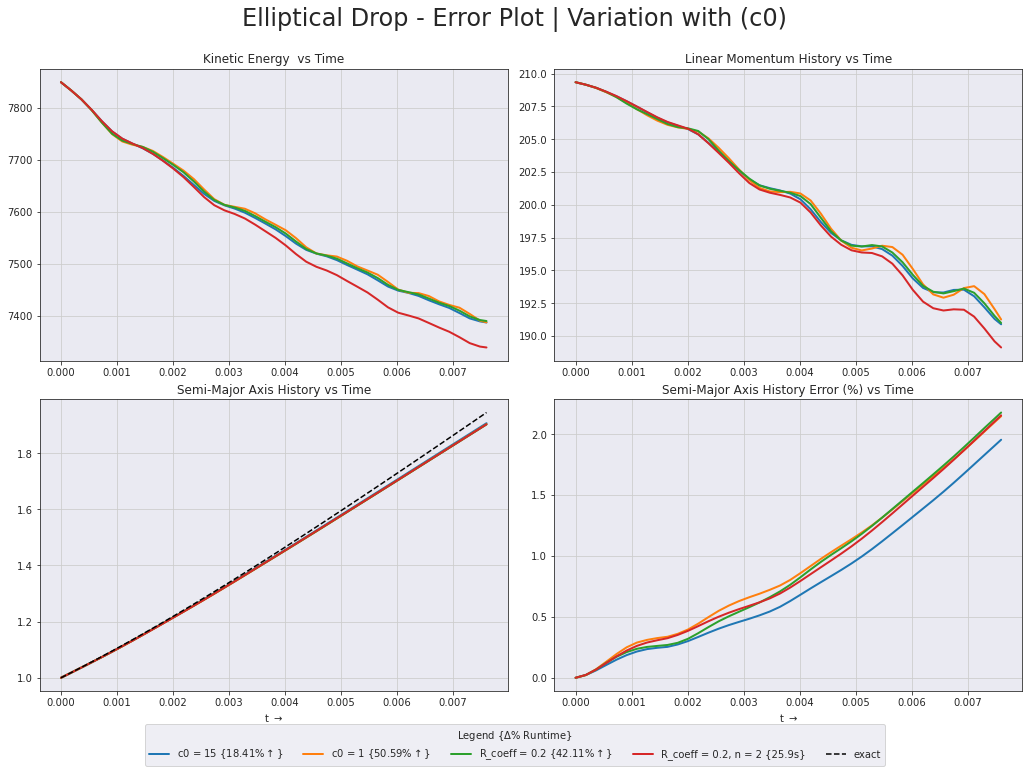

In [272]:
custom_plot1(sph_schm, sph_schm_legend, save=False, sz=(14.4,10.8))

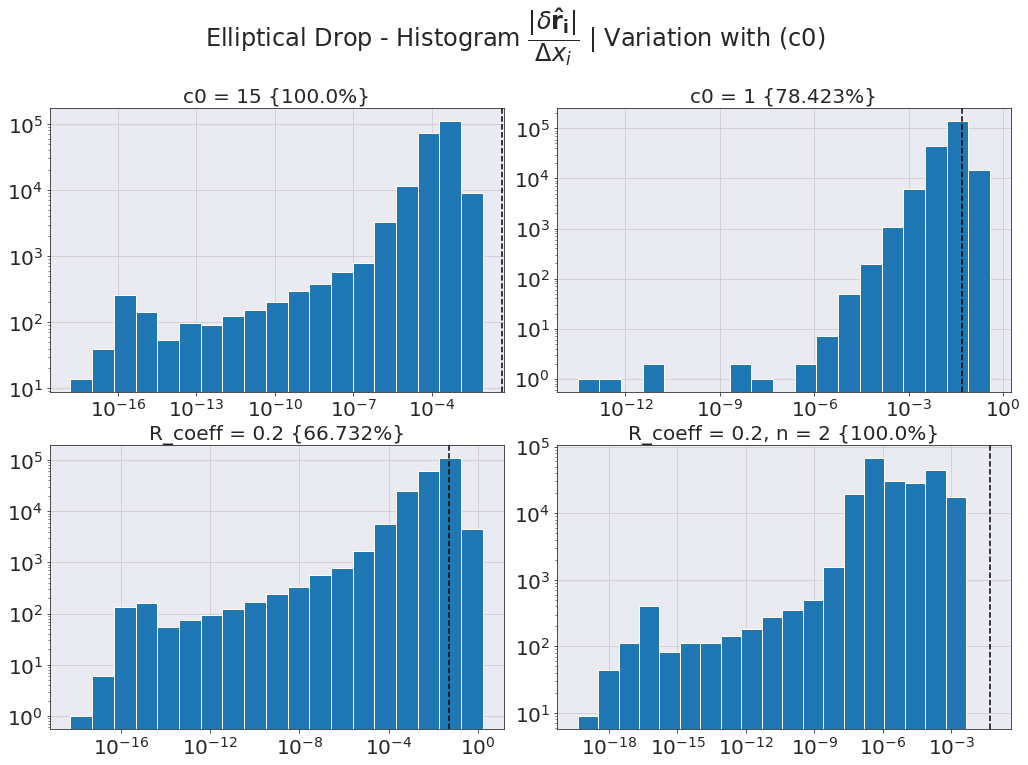

In [273]:
custom_plot4(sph_schm, sph_schm_legend, vlines=vl, save=False, sz=(14.4, 10.8))

In [142]:
#run_time_plot(sph_schm, sph_schm_legend, save=False)
#custom_plot2(sph_schm, sph_schm_legend, save=False)
#custom_plot3(sph_schm, sph_schm_legend, bins=25,save=False)